# 6주차 과제

Made by 35기 코딩부장 류제현

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. 시계열데이터(주가) 분석

    1-1) 우선 삼성전자주가, 카카오주가 csv파일을 불러옵시다 

            Date를 인덱스로 설정하고, datetime으로 변환해줍니다

In [15]:
samsung = pd.read_csv("삼성전자주가.csv", index_col=0, parse_dates=True)
kakao = pd.read_csv("카카오주가.csv", index_col=0 , parse_dates=True)

    1-2) 종가(Close)를 사용하여, 종가와 함께 **삼성전자**의 120일 이동평균선과 20일 이동평균선을 그려봅시다

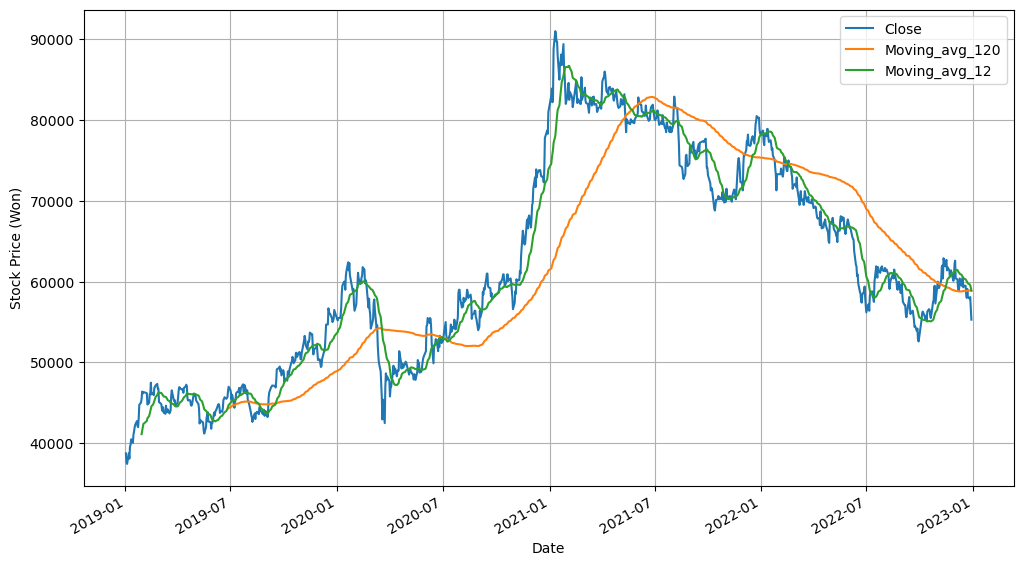

In [16]:
# 이동평균을 계산합니다
samsung["Moving_avg_120"] = samsung.Close.rolling(window=120).mean()
samsung["Moving_avg_12"] = samsung.Close.rolling(window=20).mean()

# plotting
samsung[["Close","Moving_avg_120","Moving_avg_12"]].plot(figsize=(12,7))
plt.grid()
plt.ylabel("Stock Price (Won)");

    1-3) 카카오 주가(종가)그래프에, 볼린저 밴드를 추가해봅시다 볼린저 밴드의 공식은 아래와 같습니다 (n=20, m=2를 사용합니다)

* 볼린저 밴드는 Matplotlib의 fill_between 함수를 사용해 그릴 수 있습니다 (그림의 투명도는 alpha 매개변수로 조절합니다)

---
    볼린저 밴드 공식

$BOLU = MA(TP, n) + m * \sigma[TP, n] $

$BOLD = MA(TP, n) - m * \sigma[TP, n] $


$Where: $

$BOLU = $ Upper Bollinger Band

$BOLD = $ Lower Bollinger Band

$MA = $ Moving Average

$TP = $ (High $+$ Low $+$ Close) $ \div 3 $ 

$n = $ Number of days in smoothing period (typically 20)

$m = $ Number of standard deviations (typically 2)

$\sigma[TP, n] = $ Standard Deviation over last $n$ periods of $TP$

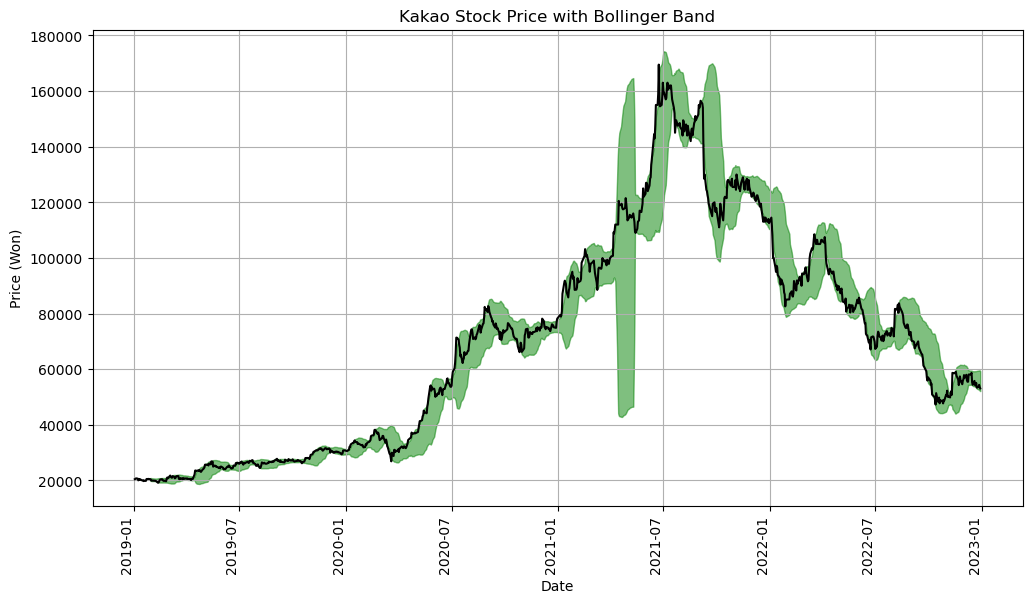

In [17]:
n = 20
m = 2

TP = (kakao.High + kakao.Low + kakao.Close) / 3 

kakao["BOLU"] = TP.rolling(window=n).mean() + m*(TP.rolling(window=n).std())
kakao["BOLD"] = TP.rolling(window=n).mean() - m*(TP.rolling(window=n).std())

plt.figure(figsize=(12,7))
kakao.Close.plot(c='k')
plt.fill_between(kakao.index, kakao.BOLU, kakao.BOLD, alpha=0.5, color='g')

plt.title("Kakao Stock Price with Bollinger Band")
plt.ylabel("Price (Won)")
plt.grid()
plt.xticks(rotation=90);

    1-4) 카카오와 삼성전자의 CAGR을 구해봅시다(종가(Close) 기준). 단, 연도별로 계산합니다 (Ex. 2020년:10%, 2021년:12% ...)

결과는 데이터프레임으로 출력해주세요 / 마지막 열은 5년간 CAGR을 기록해주세요

---

$CAGR(t_0, t_n) = ({V(t_n) \over V(t_0)})^{1 \over {t_n - t_0}} - 1$

$Where \ V(t_0)$는 시작값, $V(t_n)$는 끝값, $t_n - t_0$는 년수이다.

In [45]:
# 카카오의 연도별 CAGR
cagr_kakao = (kakao.Close.resample("Y").last() / kakao.Close.resample("Y").first()) - 1
# 카카오 5년간 CAGR
cagr_kakao_5 = (kakao.Close.iloc[-1] / kakao.Close.iloc[0])**(1/5) - 1 

# 삼성전자의 연도별 CAGR
cagr_samsung = (samsung.Close.resample("Y").last() / samsung.Close.resample("Y").first()) - 1
cagr_samsung_5 = (samsung.Close.iloc[-1] / samsung.Close.iloc[0])**(1/5) - 1 

In [56]:
# 두 시리즈를 하나의 데이터프레임으로 합쳐준다
cagr = pd.concat([cagr_kakao,cagr_samsung], axis=1, keys=["CAGR_Kakao","CAGR_Samsung"])
cagr.index = ["2019","2020","2021","2022"]

# 데이터프레임의 아래에 5년간 CAGR을 추가해준다
cagr.loc["5year_avg"] = [cagr_kakao_5, cagr_samsung_5]
cagr

,CAGR_Kakao,CAGR_Samsung
2019,0.504909,0.440000
2020,1.554118,0.467391
2021,0.415379,-0.056627
2022,-0.536245,-0.296438
5year_avg,0.209992,0.073719


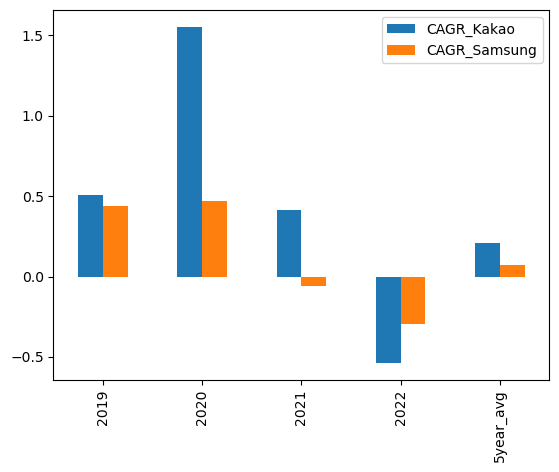

In [57]:
# CAGR 시각화
cagr.plot(kind="bar");

## 2. 주성분 분석(PCA)과 머신러닝

    음원 스트리밍 기업 Spotify에서 받아온 실제 데이터셋을 사용해 봅시다

In [ ]:
spotify = pd.read_csv("6주차과제/spotify.csv")
print(spotify.shape) #32833개의 Data

# 컬럼의 일부만 사용하겠습니다
spotify = spotify.loc[:,['playlist_genre', 'danceability',
                         'energy','loudness','speechiness', 'acousticness', 
                         'instrumentalness','liveness', 'valence', 'tempo']]
spotify.head()

    2-1) playlist_genre를 기준으로 데이터셋을 합친 후, 각각 특성의 평균을 구해 봅시다. (pandas의 groupby를 사용합니다)

        * 가장 energy의 평균이 높은 음악 장르는 무엇이고 그럴듯한가요?
        * 가장 acousticness가 높은 장르는 무엇이고 그럴듯한가요? 

In [ ]:
spotify.groupby(by="playlist_genre").mean()

# energy: EDM
# Acousticness: R&B

    2-2)  주성분 분석으로 데이터셋을 3차원으로 줄여봅시다

    * 3개의 주성분은 데이터셋의 분산을 몇 퍼센트 설명하나요? 

* 주의: 장르는 pca 모형에 넣으면 안됩니다**

In [ ]:
from sklearn.decomposition import PCA

# 장르빼고 나머지만 가져오기
spotify_x = spotify.iloc[:,1:]

pca = PCA(n_components=3)
spotify_pca = pca.fit_transform(spotify_x)

sum(pca.explained_variance_ratio_) #분산의 99.9%를 설명합니다!!

    2-3) 3개의 차원으로 줄인 데이터셋을 3차원으로 시각화해봅시다

    * scatter plot으로 그리는데, 각 point의 색상이 genre가 되도록 그리겠습니다. 아래 예시 코드가 이어집니다

In [ ]:
# 예시코드

# 데이터 생성
x = [1,2,3,4,5,6]
y = [1,2,3,4,5,6]
c = [0,0,1,1,2,2]

# 색상(c)을 하나의 색이 아닌, array로 주고, colormap을 의미하는 cmap을 지정해주변 됩니다
# 컬러맵은 다양한 것이 있는데, 여기서 확인할 수 있습니다 -> https://matplotlib.org/stable/tutorials/colors/colormaps.html#sphx-glr-tutorials-colors-colormaps-py 
plt.scatter(x,y,c=c, cmap="cool"); # binary, cool, hot 등..

In [ ]:
# PCA로 차원을 3개로 줄인 spotify 데이터셋을 시각화해봅시다

# 이 코드는 문자열로 된 장르를 숫자로 변환해줍니다(c=genre 를 해주면 되겠죠?)
genre = spotify.playlist_genre.astype('category').cat.codes

# 3d plot을 그려줍니다
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(spotify_pca[:,0], spotify_pca[:,1], spotify_pca[:,2], c=genre, cmap="hot");

    2-4) 기존 데이터셋으로, 음악 장르를 분류하는 머신러닝 모델을 만들어 봅시다 (PCA를 사용하지 않은 데이터셋으로)

**아무 알고리즘이나 사용하셔도 좋습니다!**
    
    * Train-set과 Test-set으로 데이터셋을 분리해주세요 (sklearn의 train_test_split(X_data, y_data, stratify=y_data) 꼴로 분리해주세요)
    * 1. 학습시간이 얼마나 걸렸나요?
    * 2. Test-set에 대한 정확도는 얼마인가요?

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spotify_x.values, genre.values, stratify=genre)


# 모델 학습
from sklearn.ensemble import RandomForestClassifier
random_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
t0 = time.time()
random_clf.fit(X_train, y_train)
t1 = time.time()

# 소요시간 출력
t1-t0

In [ ]:
# Test-set에 대한 예측 정확도 
random_clf.score(X_test, y_test)

    2-4) PCA로 차원을 3개로 줄인 데이터셋을 사용하여, 음악 장르를 분류하는 머신러닝 모델을 만들어 봅시다

**앞에서 사용한 알고리즘과 동일한 알고리즘을 사용해주세요!**
    
    # PCA를 사용해, 앞에서 train-test-split으로 분리한 데이터를 3개의 차원으로 축소해주세요
    * 1. 학습시간이 얼마나 걸렸나요?
    * 2. Test-set에 대한 정확도는 얼마인가요?

In [ ]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 모델 학습
pca_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
t0 = time.time()
pca_clf.fit(X_train_pca, y_train)
t1 = time.time()

# 소요시간 출력
t1-t0

In [ ]:
# Test-set에 대한 예측 정확도 
pca_clf.score(X_test_pca, y_test)